# Lab 4: Data Imputation using an Autoencoder

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.



## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1vTCEl8m8tqQ3vEqZs-RO3Xb4qCBgwhiE#scrollTo=IXQ7BP151ppz

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [0]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [0]:
df[:30] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


In [0]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


In [0]:
np.sum(subdf["caploss"])

2842700

In [0]:
#Get the summary statistics for the age, yredu, capgain, caploss and workhr
subdf.describe()

,age,yredu,capgain,caploss,workhr
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [0]:
# Normalization formula is essentially: norm(x) = (x-x_min)/(x_max-x_min)
col_names = ["age", "yredu", "capgain", "caploss", "workhr"] #declaring the column names that have values to normalize

#print(df)
for i in range(len(col_names)): #declare for loop to do this for each of the column names of interest
  col_name = col_names[i] #declare the name of the column
  x = df[col_name] #set dummy variable x
  normalized_x=(x-x.min())/(x.max()-x.min()) #create the normalized x
  df[col_name] = normalized_x #replace the columns df values with the normalized values

#Now output the summary statistics of the numerical values to show how they differ
df.describe()


,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,1.897784e+05,0.605379,0.010777,0.020042,0.402423
std,0.186855,1.055500e+05,0.171515,0.073854,0.092507,0.125994
min,0.000000,1.228500e+04,0.000000,0.000000,0.000000,0.000000
25%,0.150685,1.178270e+05,0.533333,0.000000,0.000000,0.397959
50%,0.273973,1.783560e+05,0.600000,0.000000,0.000000,0.397959
75%,0.424658,2.370510e+05,0.733333,0.000000,0.000000,0.448980
max,1.000000,1.484705e+06,1.000000,1.000000,1.000000,1.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [0]:
# hint: you can do something like this in pandas
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")

ratio_male = round(100*num_male/len(df), 2)
ratio_female = round(100*num_female/len(df), 2)
print('The % of males are:',ratio_male, '%')
print('The % of females are:',ratio_female, '%')

The % of males are: 66.92 %
The % of females are: 33.08 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"] #continuous value columns
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"] #categorical value columns
features = contcols + catcols
df = df[features]


In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print(df_with_missing.shape) 
print(df_not_missing.shape)
print('% Missing:',(df_with_missing.shape[0]/len(df)*100),'%')

(1843, 11)
(30718, 11)
% Missing: 5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? 

In [0]:
df_not_missing['work'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
Name: work, dtype: int64

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [0]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [0]:
row,col = data.shape
print('The number of columns in the encoded dataframe is: ', col)

The number of columns in the encoded dataframe is:  57


#####Answer
The addition of many columns came from taking all of the possible categorical values, and essentially making them into new columns, where any row which had the original categorical text for the corresponding column, would instead turn into a 1, and stay a 0 for the other possible values in that row. This makes our data 100% numerical, thus making it much easier to navigate.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    
    """
    From the description of the problem as well as the sample examples, the objective is to output the categorical value
    based on the position of the maximum value of a numpy array in the first input of the get_categorical_value function
    """
    
    # <----- TODO: WRITE YOUR CODE HERE ----->
       
    # In order to do this, take the index of the first input array's maximum and use that in the categorical values to output the string
    max_pos = np.unravel_index(np.argmax(onehot), onehot.shape)[0] #generates the position of the maximum value; the predicted categorical feature
    #max_pos = onehot.index(max(onehot)) 
    category = cat_values[feature]
    output = category[max_pos]
    
    return output



In [0]:
## TEST ON THE SAMPLE EXAMPLES GIVEN IN THE PROBLEM DESCRIPTION
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))

# Function works well

Private
State-gov


In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [0]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
np.random.shuffle(datanp)
row, col = datanp.shape
train_row = round(0.7*row) #indexing from training data
val_row = round(0.15*row) #indexing for validation data

train_data = datanp[0:train_row]
val_data = datanp[train_row:train_row+val_row]
test_data = datanp[-val_row:]

print('Number of rows in the training data is:',train_data.shape[0])
print('Number of rows in the validation data is:',val_data.shape[0])
print('Number of rows in the testing data is:',test_data.shape[0])



Number of rows in the training data is: 21503
Number of rows in the validation data is: 4608
Number of rows in the testing data is: 4608


In [0]:
#Sample data point for the training data
train_data[10]

array([0.15068494, 0.8       , 0.        , 0.        , 0.4489796 ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 0.        ], dtype=float32)

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.


In [0]:
from torch import nn

class DataForge(nn.Module):
    def __init__(self):
        encoder_dim = 11
        super(DataForge, self).__init__()
        self.name= "dataforge"
        self.encoder = nn.Sequential(
            nn.Linear(57, 15), 
            nn.ReLU(),
            nn.Linear(15, encoder_dim),
            nn.ReLU() 
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoder_dim, 15),
            nn.Linear(15, 57), 
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
      
     

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

This is due to the fact that the data in the columns for the categorical one-hot encoded values are normalized, and thus must have values returned between 0 or 1

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
    import matplotlib.pyplot as plt

In [0]:
## HELPER FUNCTIONS
def zero_out_feature(records, feature): ##zeros out a selected one hot feature 
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature] #takes the starting one-hot encoded index for the feature in question
    stop_index = cat_index[feature] + len(cat_values[feature]) # take the last index value of the feature
    records[:, start_index:stop_index] = 0 #make all of the values 0 (effectively only turns 1 of the ones to a 0)
    return records

def zero_out_random_feature(records): #essentially calls the previous function, but randomizes the feature that is being zeroed 
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols)) #random.choice = takes a random index selection from a list
    #returns the zeroed out records

# TRAINING CHECKPOINTING FUNCTION 
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# TRAINING FUNCTION
def train(model, train_loader, valid_loader, num_epochs, learning_rate, batch_size):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss() #mean squared error loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #adam optimization

    train_loss = np.zeros(num_epochs) # make an empty vector for the training loss values accrued
    train_acc = np.zeros(num_epochs) # make an empty vector for the training accuracy values accrued

    val_loss = np.zeros(num_epochs) # make an empty vector for the validation loss values accrued
    val_acc = np.zeros(num_epochs) # make an empty vector for the validation accuracy values accrued

    for epoch in range(num_epochs):
        total_train_loss = 0.0 #set an initial 0 value for the total trained loss of this epoch

        for iterations, data in enumerate(train_loader, 0):
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam) #reconstruction

            #forward/backwards pass and optimization
            loss = criterion(recon, data) #loss value
            loss.backward()
            optimizer.step() #optimizting and changing the hidden unit parameter values
            optimizer.zero_grad() #resets the gradient values to zero for next usage

            #generate the training loss values and updates
            total_train_loss += loss.item() #add the calculated MSE loss value from the MSE tensor to the total training loss

        train_loss[epoch] = float(total_train_loss/(iterations+1))
        val_loss[epoch] = evaluate(model, val_loader, criterion) #generates the average training loss of the epoch

        # Get accuracy values
        train_acc[epoch] = get_accuracy(model, train_loader) #generate the training accuracy for this epoch
        val_acc[epoch] = get_accuracy(model, val_loader) #generate the validation accuracy for this epoch

        # Print out the values of the function
        print(("Epoch {}: Train accuracy =  {}, Train loss =  {} | "+
               "Validation accuracy =  {}, Validation loss =  {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
       
        # Save the current model (checkpoint) to a file every epoch
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # Plotting Curves
    plt.title("Training 1")
    plt.plot(np.arange(num_epochs), train_loss, label="Train")
    plt.plot(np.arange(num_epochs), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training 2")
    plt.plot(np.arange(num_epochs), train_acc, label="Train")
    plt.plot(np.arange(num_epochs), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def evaluate(model, loader, criterion): # evaluation of the loss on the validation set
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0

    i = 0
    for col in catcols: #validating this for every column in the validation set
      for data in (loader):
        datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
        recon = model(datam) #reconstruction of validation data

        loss = criterion(recon, data) #loss value of validation
        total_loss += loss.item()
        i+=1 #increase iteration number

    loss = float(total_loss)/(i + 1)
    return loss


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train accuracy =  0.3463237687764498, Train loss =  0.19563408964313567 | Validation accuracy =  0.34642650462962965, Validation loss =  0.12474206714444078
Epoch 2: Train accuracy =  0.4572462757134663, Train loss =  0.08625968852789984 | Validation accuracy =  0.45460792824074076, Validation loss =  0.07320911013494337
Epoch 3: Train accuracy =  0.45983506177432604, Train loss =  0.07195092300840077 | Validation accuracy =  0.45851417824074076, Validation loss =  0.07121478056459758
Epoch 4: Train accuracy =  0.459362259529678, Train loss =  0.0709237472786169 | Validation accuracy =  0.4576822916666667, Validation loss =  0.07054867806892863
Epoch 5: Train accuracy =  0.45866468244741043, Train loss =  0.07029939904099419 | Validation accuracy =  0.45750144675925924, Validation loss =  0.06988711364438079
Epoch 6: Train accuracy =  0.4596335395061154, Train loss =  0.06948890866866957 | Validation accuracy =  0.45873119212962965, Validation loss =  0.06886997329706401
Epoch

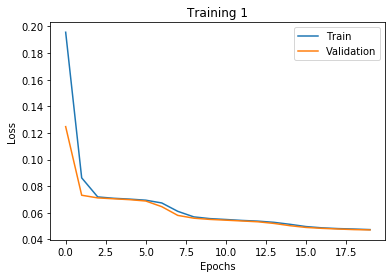

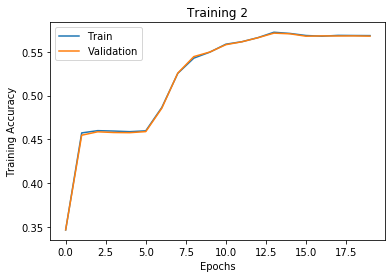

In [0]:
encoder= DataForge()
"""use_cuda = True

if use_cuda and torch.cuda.is_available():
  encoder.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
"""

batch_size= 32
train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle= True)
val_loader= torch.utils.data.DataLoader(val_data, batch_size= batch_size, shuffle= True)

train(encoder, train_loader, val_loader, num_epochs= 20, learning_rate= 0.0001, batch_size= batch_size)

NOTE: THE TRAIN AND VALIDATION ARE ALMOST IDENTICAL THROUGHOUT THE ENTIRE TRAINING. SHOWS HIGH SIMILARITY BETWEEN THE TRAINING AND VALIDATION SET

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [0]:
## declare variables for the tuning
bs1 = 32
bs2 = 64
num1 = 25
num2 = 50
lr1 = 0.001
lr2 = 0.0005

Epoch 1: Train accuracy =  0.5700522407726054, Train loss =  0.04653508836470012 | Validation accuracy =  0.5708912037037037, Validation loss =  0.04524308021874786
Epoch 2: Train accuracy =  0.5848408749166782, Train loss =  0.04224687640366721 | Validation accuracy =  0.5835141782407407, Validation loss =  0.03919338042164124
Epoch 3: Train accuracy =  0.5881737431986235, Train loss =  0.037793324170966765 | Validation accuracy =  0.5882884837962963, Validation loss =  0.03693833244759912
Epoch 4: Train accuracy =  0.5947619711978174, Train loss =  0.0365899731959438 | Validation accuracy =  0.5959563078703703, Validation loss =  0.03584704107330369
Epoch 5: Train accuracy =  0.5997457719077958, Train loss =  0.035482813130199374 | Validation accuracy =  0.6001157407407407, Validation loss =  0.035171736514120436
Epoch 6: Train accuracy =  0.6051946240059527, Train loss =  0.03490503394277766 | Validation accuracy =  0.6030815972222222, Validation loss =  0.03464162632435388
Epoch 7:

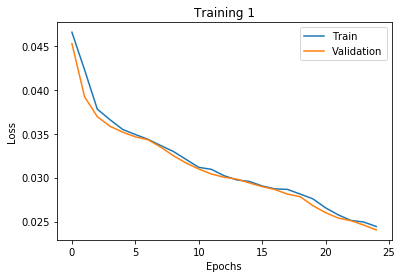

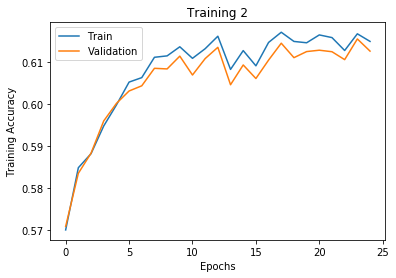

In [0]:
train(encoder, train_loader, val_loader, num_epochs= num1, learning_rate= lr2, batch_size= bs1)

Epoch 1: Train accuracy =  0.607318358678634, Train loss =  0.023770330702453584 | Validation accuracy =  0.6060112847222222, Validation loss =  0.023219292731471143
Epoch 2: Train accuracy =  0.6103334418453239, Train loss =  0.02291248441075108 | Validation accuracy =  0.6107494212962963, Validation loss =  0.022663932139689178
Epoch 3: Train accuracy =  0.6129299787626533, Train loss =  0.022272962803808263 | Validation accuracy =  0.6129195601851852, Validation loss =  0.02183533931807803
Epoch 4: Train accuracy =  0.6157590413740718, Train loss =  0.021736836757987647 | Validation accuracy =  0.6159939236111112, Validation loss =  0.02138216823145661
Epoch 5: Train accuracy =  0.6158830550775861, Train loss =  0.021357356215871516 | Validation accuracy =  0.6143301504629629, Validation loss =  0.02141039551079618
Epoch 6: Train accuracy =  0.6173402160938783, Train loss =  0.021293726311774834 | Validation accuracy =  0.6154875578703703, Validation loss =  0.021304510455212495
Epo

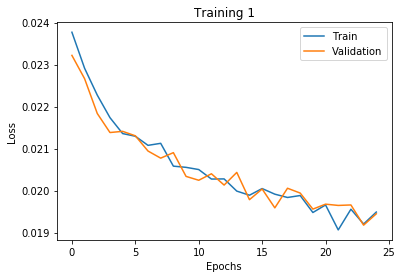

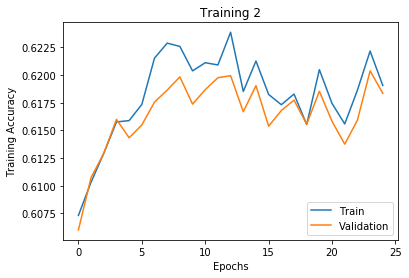

In [0]:
train(encoder, train_loader, val_loader, num_epochs= num1, learning_rate= lr1, batch_size= bs2)

Epoch 1: Train accuracy =  0.6206808352322931, Train loss =  0.018880255678336004 | Validation accuracy =  0.6195023148148148, Validation loss =  0.01919139384512784
Epoch 2: Train accuracy =  0.6236184098342867, Train loss =  0.019129547397218023 | Validation accuracy =  0.6213831018518519, Validation loss =  0.01907813691270317
Epoch 3: Train accuracy =  0.6247035297400363, Train loss =  0.018813603116931126 | Validation accuracy =  0.6216001157407407, Validation loss =  0.01886399648329943
Epoch 4: Train accuracy =  0.6212854020369251, Train loss =  0.018552237716946928 | Validation accuracy =  0.6197193287037037, Validation loss =  0.01879138927852918
Epoch 5: Train accuracy =  0.623804430389558, Train loss =  0.018623658374140394 | Validation accuracy =  0.6226128472222222, Validation loss =  0.018720993733927178
Epoch 6: Train accuracy =  0.6224325287944318, Train loss =  0.018690431331162386 | Validation accuracy =  0.6205873842592593, Validation loss =  0.01875030780534093
Epoc

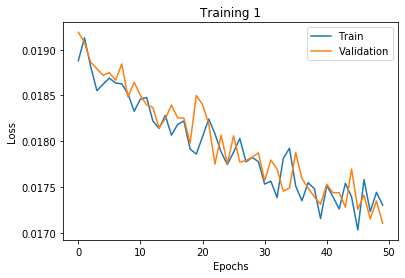

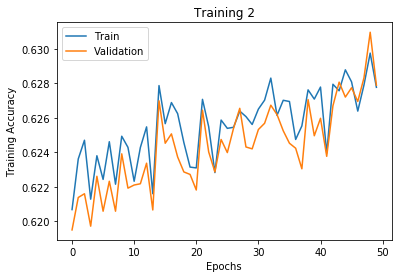

In [0]:
train(encoder, train_loader, val_loader, num_epochs= num2, learning_rate= lr2, batch_size= bs1)

Epoch 1: Train accuracy =  0.6254708645305306, Train loss =  0.01764626449689136 | Validation accuracy =  0.6252531828703703, Validation loss =  0.01720815994803702
Epoch 2: Train accuracy =  0.6302376412593591, Train loss =  0.01724946975411426 | Validation accuracy =  0.6290147569444444, Validation loss =  0.017416398241211568
Epoch 3: Train accuracy =  0.6290285076500953, Train loss =  0.017443680514198995 | Validation accuracy =  0.6291956018518519, Validation loss =  0.017450542801269734
Epoch 4: Train accuracy =  0.6282689237160706, Train loss =  0.01713458807110631 | Validation accuracy =  0.6278211805555556, Validation loss =  0.017543603464788785
Epoch 5: Train accuracy =  0.6285479545489777, Train loss =  0.017079137380711644 | Validation accuracy =  0.6294487847222222, Validation loss =  0.017455102859140304
Epoch 6: Train accuracy =  0.6277806197584833, Train loss =  0.017541620204740736 | Validation accuracy =  0.6274594907407407, Validation loss =  0.017204875017737032
Ep

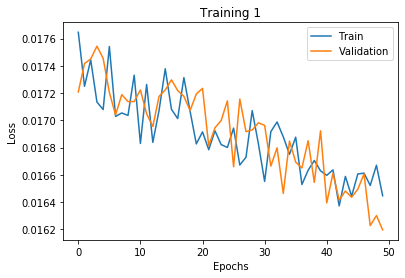

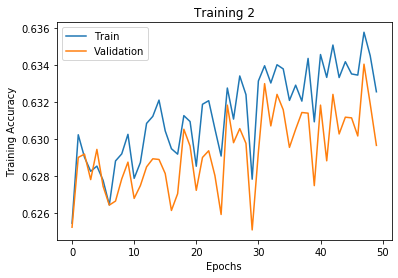

In [0]:
train(encoder, train_loader, val_loader, num_epochs= num2, learning_rate= lr1, batch_size= bs2)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

Epoch 1: Train accuracy =  0.6322699652777778, Train loss =  0.016293372933028474 | Validation accuracy =  0.6311125578703703, Validation loss =  0.0165741067788849
Epoch 2: Train accuracy =  0.6269169560185185, Train loss =  0.015712651210681845 | Validation accuracy =  0.6282913773148148, Validation loss =  0.016566273892524443
Epoch 3: Train accuracy =  0.6325231481481481, Train loss =  0.016235415435706575 | Validation accuracy =  0.6309678819444444, Validation loss =  0.016452305343518884
Epoch 4: Train accuracy =  0.6322337962962963, Train loss =  0.016150059540652566 | Validation accuracy =  0.6308232060185185, Validation loss =  0.016359752070460188
Epoch 5: Train accuracy =  0.6347294560185185, Train loss =  0.016096456396755658 | Validation accuracy =  0.6326678240740741, Validation loss =  0.016150200264151558
Epoch 6: Train accuracy =  0.6341145833333334, Train loss =  0.016053077787445445 | Validation accuracy =  0.6321976273148148, Validation loss =  0.01631958833976374
E

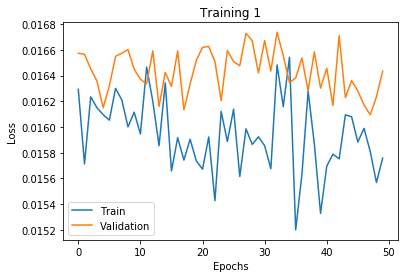

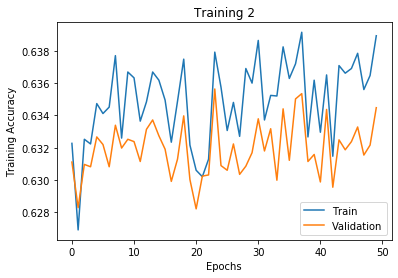

In [0]:
batch_size= 32
test_loader= torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle= True)

train(encoder, test_loader, val_loader, num_epochs= num2, learning_rate= lr1, batch_size= bs2)

(I missed the note about not having the graphs included).

1) Increasing the learning rate to allow for convergence of a solution faster
2) Increasing the batch size to allow for greater amount of training data to be assessed per iteration and also brought the learning rate to original
3) Increased the number of epochs and reduced the learning rate (to potentially reach divergence/overfitting)
4) Kept highest epoch, increased the learning rate and batch size to get the faster convergence.

In [0]:
model_path = get_model_name("dataforge", batch_size= bs2, learning_rate= lr1, epoch=num2-1)
state = torch.load(model_path)

encoder = DataForge()
encoder.load_state_dict(state)

test_loader= torch.utils.data.DataLoader(test_data, batch_size= bs2, shuffle= True)

test_acc= get_accuracy(encoder, test_loader)

print('The test accuracy is', (np.round(test_acc * 100, 2)),'%')

The test accuracy is 63.89 %


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?

**Do not actually implement this baseline model. You should be able to compute the 
test accuracy by reasoning about how the basline model behaves.**

In [0]:
## To see accuracy of baseline for test data, take the maximum value ratio for marriage to see how that compares to the developed model accuracy
print(catcols) #name of each category
print(cat_values) #value of each category

['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}
Federal-gov


In [0]:
#reformation of the column names 
col_max = [] #empty list for the new column names

for i in range(len(catcols)):
  s = str(catcols[i])
  ss = len(cat_values[s])
  col_sum = []
  for j in range(ss):
    reform_col = str(s)+'_ '+str(cat_values[s][j])
    catsum = data[str(reform_col)].sum()
    col_sum.append(catsum)
  col_max.append(max(col_sum))
print(col_max)

#Below is the maximum value for each of the categorizations (i.e. the highest occuring value)
#If for the training data, the max value was inputted for each missing categorization, probability of accuracy would
#reach the ratio of the max category to the ratio.


[22696, 14339, 4140, 9968, 12704, 20788]


In [0]:
#Average accuracy
average_col_count = int(sum(col_max)/len(col_max))
baseline_accuracy = round(float(average_col_count/len(data)),4)*100
print('The baseline accuracy is',baseline_accuracy,'%')

The baseline accuracy is 45.92 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Baseline accuracy is lower than the predicted ~64% accuracy I got 

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [0]:
pd.DataFrame(data= [test_data[0]], columns= data.columns)

#I do not think this is a very valid statement; the correlation between education level and the type of work, gender, marriage, capgain, etc. is so
#variable that it is not easy to make any generalizations that can lead to such an assumption

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.657534,0.8,0.067231,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
test_loader= torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
for item in loader:  
  inp = item.detach().numpy()
  out = encoder(zero_out_feature(item.clone(), "edu")).detach().numpy()
  print(get_feature(out[0], "edu"))
  break

Masters


Prediction is that the individual has a master's degree

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
education = []
ss = len(cat_values['edu'])
for j in range(ss):
  reform_col = 'edu'+'_ '+str(cat_values['edu'][j])
  education.append(reform_col)
pd.DataFrame(data[education].sum(),).sort_values(by=0,ascending=False)

## Expected output of the baseline model would by HS-grad

,0
edu_ HS-grad,9968
edu_ Some-college,6775
edu_ Bachelors,5182
edu_ Masters,1675
edu_ Assoc-voc,1321
edu_ 11th,1056
edu_ Assoc-acdm,1020
edu_ 10th,831
edu_ 7th-8th,573
edu_ Prof-school,558
